In [19]:
import os
import json
import pandas as pd

def extract_data(base_path: str):
    """
    Extract raw triplet rows and disease-level info from TSV/JSON files.
    Returns:
        full_df (pd.DataFrame): one row per triplet
        disease_info (dict): per-disease counts and PubMed ID sets
    """
    rows = []
    disease_info = {}

    for disease in os.listdir(base_path):
        folder = os.path.join(base_path, disease)
        if not os.path.isdir(folder):
            continue

        # Count initial and filtered PubMed IDs
        initial = filtered = 0
        for fn in os.listdir(folder):
            path = os.path.join(folder, fn)
            if fn.endswith('_no_replaced.tsv'):
                initial = sum(1 for _ in open(path)) - 1
            if fn.endswith('_filtered.tsv'):
                filtered = sum(1 for _ in open(path)) - 1

        # Load JSON triplets
        json_path = os.path.join(folder, 'final_automaxo_results.json')
        if not os.path.exists(json_path):
            continue
        data = json.load(open(json_path))

        info = disease_info.setdefault(disease, {
            'initial_pubmed_count': initial,
            'filtered_pubmed_count': filtered,
            'triplet_count': 0,
            'unique_pubmed_ids': set()
        })

        for entry in data.get('triplets', []):
            t = entry['triplet']
            sources = entry.get('source', {})

            info['unique_pubmed_ids'].update(sources.keys())
            info['triplet_count'] += 1

            rows.append({
                'disease': disease,
                'maxo': t.get('maxo'),
                'hpo': t.get('hpo'),
                'mondo': t.get('mondo'),
                'non_grounded_maxo': t.get('non_grounded_maxo'),
                'non_grounded_hpo': t.get('non_grounded_hpo'),
                'non_grounded_mondo': t.get('non_grounded_mondo'),
                'potential_maxo': t.get('potential_maxo', []),
                'potential_hpo': t.get('potential_hpo', []),
                'potential_mondo': t.get('potential_mondo', []),
                'no_of_titles': sum(1 for d in sources.values() if 'title' in d),
                'no_of_abstracts': sum(1 for d in sources.values() if 'abstract' in d)
            })

    full_df = pd.DataFrame(rows)
    return full_df, disease_info

def clean_data(full_df: pd.DataFrame):
    """
    Replace literal "None" strings with actual NA values.
    """
    cols_to_clean = [
        'maxo', 'hpo', 'mondo',
        'non_grounded_maxo', 'non_grounded_hpo', 'non_grounded_mondo'
    ]
    for col in cols_to_clean:
        full_df[col] = full_df[col].replace("None", pd.NA)
    return full_df

def summarize_data(full_df: pd.DataFrame, disease_info: dict):
    """
    Summarize metrics per disease based on the cleaned full_df and disease_info.
    Returns:
        summary_df (pd.DataFrame): one row per disease with all metrics
    """
    def count_potential(sub, col):
        ids = set()
        for lst in sub[col].dropna():
            for item in lst:
                if isinstance(item, dict) and 'id' in item:
                    ids.add(item['id'])
                elif isinstance(item, str):
                    ids.add(item)
        return len(ids)

    summary_rows = []
    for disease, info in disease_info.items():
        sub = full_df[full_df['disease'] == disease]
        total_titles = sub['no_of_titles'].sum()
        total_abstracts = sub['no_of_abstracts'].sum()

        unique_maxo = sub['maxo'].nunique(dropna=True)
        total_maxo = sub['maxo'].count()
        unique_hpo = sub['hpo'].nunique(dropna=True)
        total_hpo = sub['hpo'].count()
        unique_mondo = sub['mondo'].nunique(dropna=True)
        total_mondo = sub['mondo'].count()

        ng_maxo = sub['non_grounded_maxo'].notna().sum()
        ng_hpo = sub['non_grounded_hpo'].notna().sum()
        ng_mondo = sub['non_grounded_mondo'].notna().sum()
        total_non_grounded = ng_maxo + ng_hpo + ng_mondo

        pot_maxo = count_potential(sub, 'potential_maxo')
        pot_hpo = count_potential(sub, 'potential_hpo')
        pot_mondo = count_potential(sub, 'potential_mondo')
        total_potential = pot_maxo + pot_hpo + pot_mondo

        summary_rows.append({
            'Disease': disease,
            'initial_pubmed_count': info['initial_pubmed_count'],
            'filtered_pubmed_count': info['filtered_pubmed_count'],
            'unique_pubmed_ids': len(info['unique_pubmed_ids']),
            'triplet_count': info['triplet_count'],
            'total_titles': total_titles,
            'total_abstracts': total_abstracts,
            'unique_maxo': unique_maxo,
            'total_maxo': total_maxo,
            'unique_hpo': unique_hpo,
            'total_hpo': total_hpo,
            'unique_mondo': unique_mondo,
            'total_mondo': total_mondo,
            'total_non_grounded': total_non_grounded,
            'non_grounded_maxo': ng_maxo,
            'non_grounded_hpo': ng_hpo,
            'non_grounded_mondo': ng_mondo,
            'total_potential': total_potential,
            'potential_maxo': pot_maxo,
            'potential_hpo': pot_hpo,
            'potential_mondo': pot_mondo
        })

    return pd.DataFrame(summary_rows)



In [20]:
base_path = '../data'
full_disease_analysis_df, disease_info = extract_data(base_path)
full_disease_analysis_df = clean_data(full_disease_analysis_df)
disease_summary = summarize_data(full_disease_analysis_df, disease_info)


In [21]:
disease_summary

,Disease,initial_pubmed_count,filtered_pubmed_count,unique_pubmed_ids,triplet_count,total_titles,total_abstracts,unique_maxo,total_maxo,unique_hpo,...,unique_mondo,total_mondo,total_non_grounded,non_grounded_maxo,non_grounded_hpo,non_grounded_mondo,total_potential,potential_maxo,potential_hpo,potential_mondo
0,dravet_syndrome,99,78,77,342,344,344,12,41,26,...,8,239,605,301,201,103,9,1,4,4
1,familial_mediterranean_fever,100,84,80,377,377,377,13,33,42,...,22,323,685,344,287,54,12,1,4,7
2,loeys_dietz_syndrome,35,34,33,139,144,144,12,18,19,...,2,85,271,121,96,54,4,1,1,2
3,donnai-barrow_syndrome,3,3,3,20,20,20,8,8,5,...,1,13,27,12,8,7,2,0,1,1
4,primary_ciliary_dyskinesia,98,76,72,325,325,325,18,31,29,...,12,244,634,294,259,81,20,5,12,3
5,camurati_engelmann,14,12,11,34,34,34,3,6,9,...,2,28,54,28,20,6,4,1,2,1
6,sickle_cell,2000,990,958,3829,3917,3917,65,452,144,...,55,2466,7899,3377,3159,1363,102,25,51,26
7,gaucher_disease,99,88,87,365,368,368,14,42,45,...,10,244,710,323,266,121,11,4,2,5
8,celiac_disease,2000,1240,1165,4718,4878,4878,67,313,219,...,90,2846,9917,4405,3640,1872,158,20,96,42
9,canavan_disease,39,20,20,76,76,76,4,13,5,...,8,45,162,63,68,31,4,1,0,3


In [22]:
full_disease_analysis_df

,disease,maxo,hpo,mondo,non_grounded_maxo,non_grounded_hpo,non_grounded_mondo,potential_maxo,potential_hpo,potential_mondo,no_of_titles,no_of_abstracts
0,dravet_syndrome,<NA>,<NA>,<NA>,add-on therapy,seizure frequency,drug-resistant focal epilepsy,[],[],[],2,2
1,dravet_syndrome,<NA>,hp:0001250,mondo:0100135,use of cannabidiol,<NA>,<NA>,[],[],[],2,2
2,dravet_syndrome,<NA>,<NA>,<NA>,access to syndrome-specific treatment options,mismanagement,dravet syndrome,[],[],"[{'id': 'MONDO:0100135', 'label': 'Dravet synd...",1,1
3,dravet_syndrome,<NA>,<NA>,<NA>,add-on stiripentol treatment,seizure frequency,refractory epilepsies,[],[],[],1,1
4,dravet_syndrome,<NA>,<NA>,<NA>,add-on therapy,gastrointestinal adverse effects,drug-resistant focal epilepsy,[],[],[],1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15935,stickler_syndrome,maxo:0000571,<NA>,mondo:0019354,<NA>,open-bite deformity,<NA>,[],[],[],1,1
15936,stickler_syndrome,maxo:0000571,hp:0000689,mondo:0009869,<NA>,<NA>,<NA>,[],[],[],1,1
15937,stickler_syndrome,maxo:0001085,hp:0012230,mondo:0019354,<NA>,<NA>,<NA>,[],[],[],1,1
15938,stickler_syndrome,maxo:0009072,hp:0000541,<NA>,<NA>,<NA>,chronic pediatric retinal detachment,[],[],[],1,1


In [23]:
# Save full_df to an Excel file
full_disease_analysis_df.to_excel('full_disease_analysis_gpt_4_all_diseases.xlsx', index=False)

# Save disease_summary to an Excel file
disease_summary.to_excel('disease_summary_gpt_4_all_diseases.xlsx', index=False)

### LLM Analysis

In [24]:
import os
import pandas as pd

import matplotlib.pyplot as plt

# Define the base paths for each model
models = ['gpt_4', 'gpt_4o_mini', 'LLaMA']
base_paths = {model: f'{model}' for model in models}



# Initialize a dictionary to store the summed results for each model
model_summaries = {}

# Process each model
for model, path in base_paths.items():
    # Extract, clean, and summarize data for the current model
    full_df, disease_info = extract_data(path)
    full_df = clean_data(full_df)
    disease_summary = summarize_data(full_df, disease_info)
    
    # Sum the columns (excluding the 'Disease' column)
    summed_summary = disease_summary.drop(columns=['Disease']).sum()
    model_summaries[model] = summed_summary

# Convert the model summaries into a DataFrame for plotting
summary_df = pd.DataFrame(model_summaries).T

In [25]:
summary_df

,initial_pubmed_count,filtered_pubmed_count,unique_pubmed_ids,triplet_count,total_titles,total_abstracts,unique_maxo,total_maxo,unique_hpo,total_hpo,unique_mondo,total_mondo,total_non_grounded,non_grounded_maxo,non_grounded_hpo,non_grounded_mondo,total_potential,potential_maxo,potential_hpo,potential_mondo
gpt_4,511,358,498,2058,2071,2071,74,302,169,436,81,1469,3967,1756,1622,589,82,25,23,34
gpt_4o_mini,511,358,458,2076,2098,2098,67,118,172,243,86,306,5561,1958,1833,1770,19,2,3,14
LLaMA,511,358,171,302,304,304,18,19,16,17,27,37,833,283,285,265,0,0,0,0


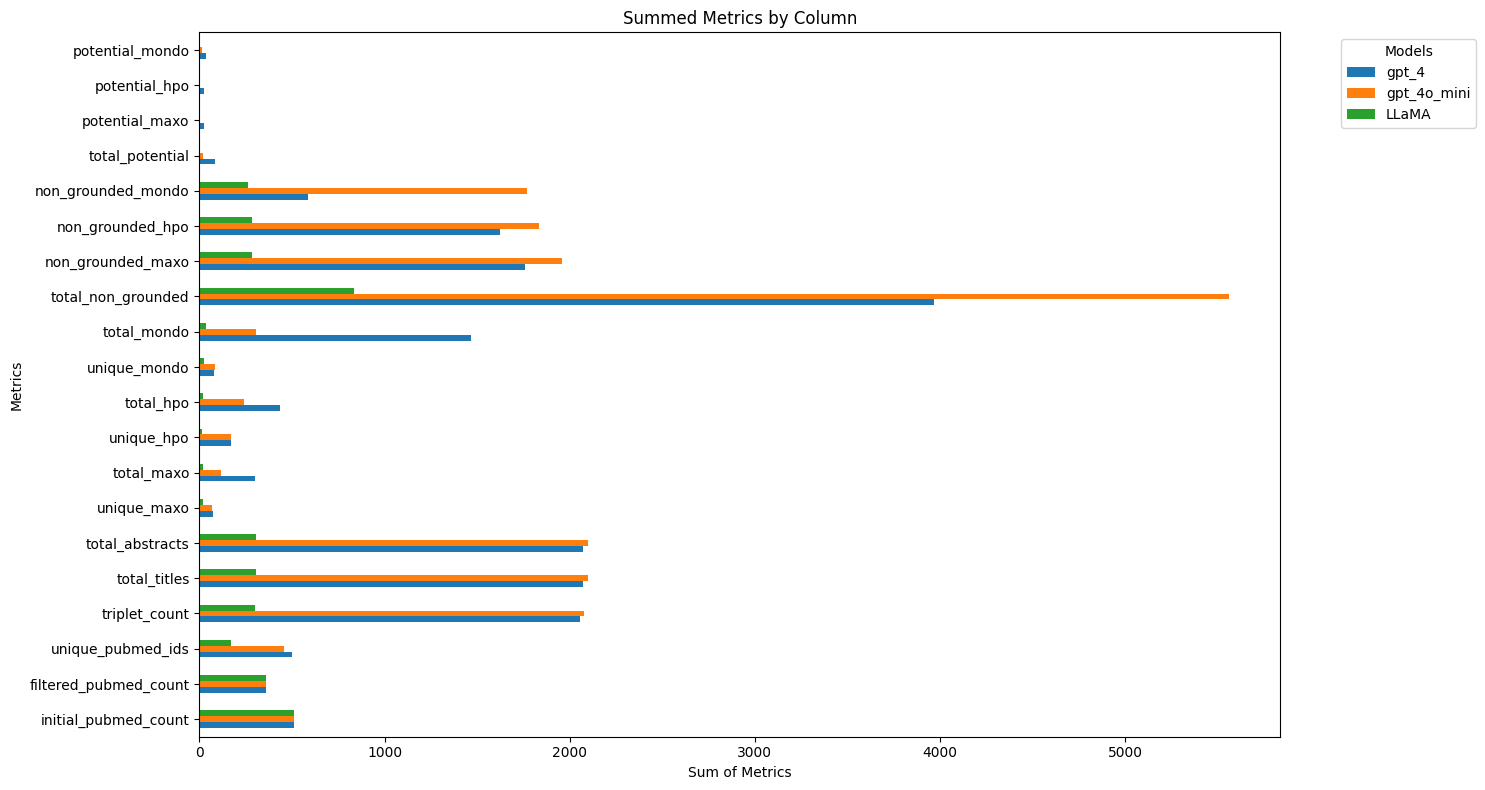

In [26]:
# Transpose the DataFrame to group by columns instead of models
transposed_summary_df = summary_df.T

# Plot the results as a horizontal bar chart
transposed_summary_df.plot(kind='barh', figsize=(15, 8))
plt.title('Summed Metrics by Column')
plt.xlabel('Sum of Metrics')
plt.ylabel('Metrics')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

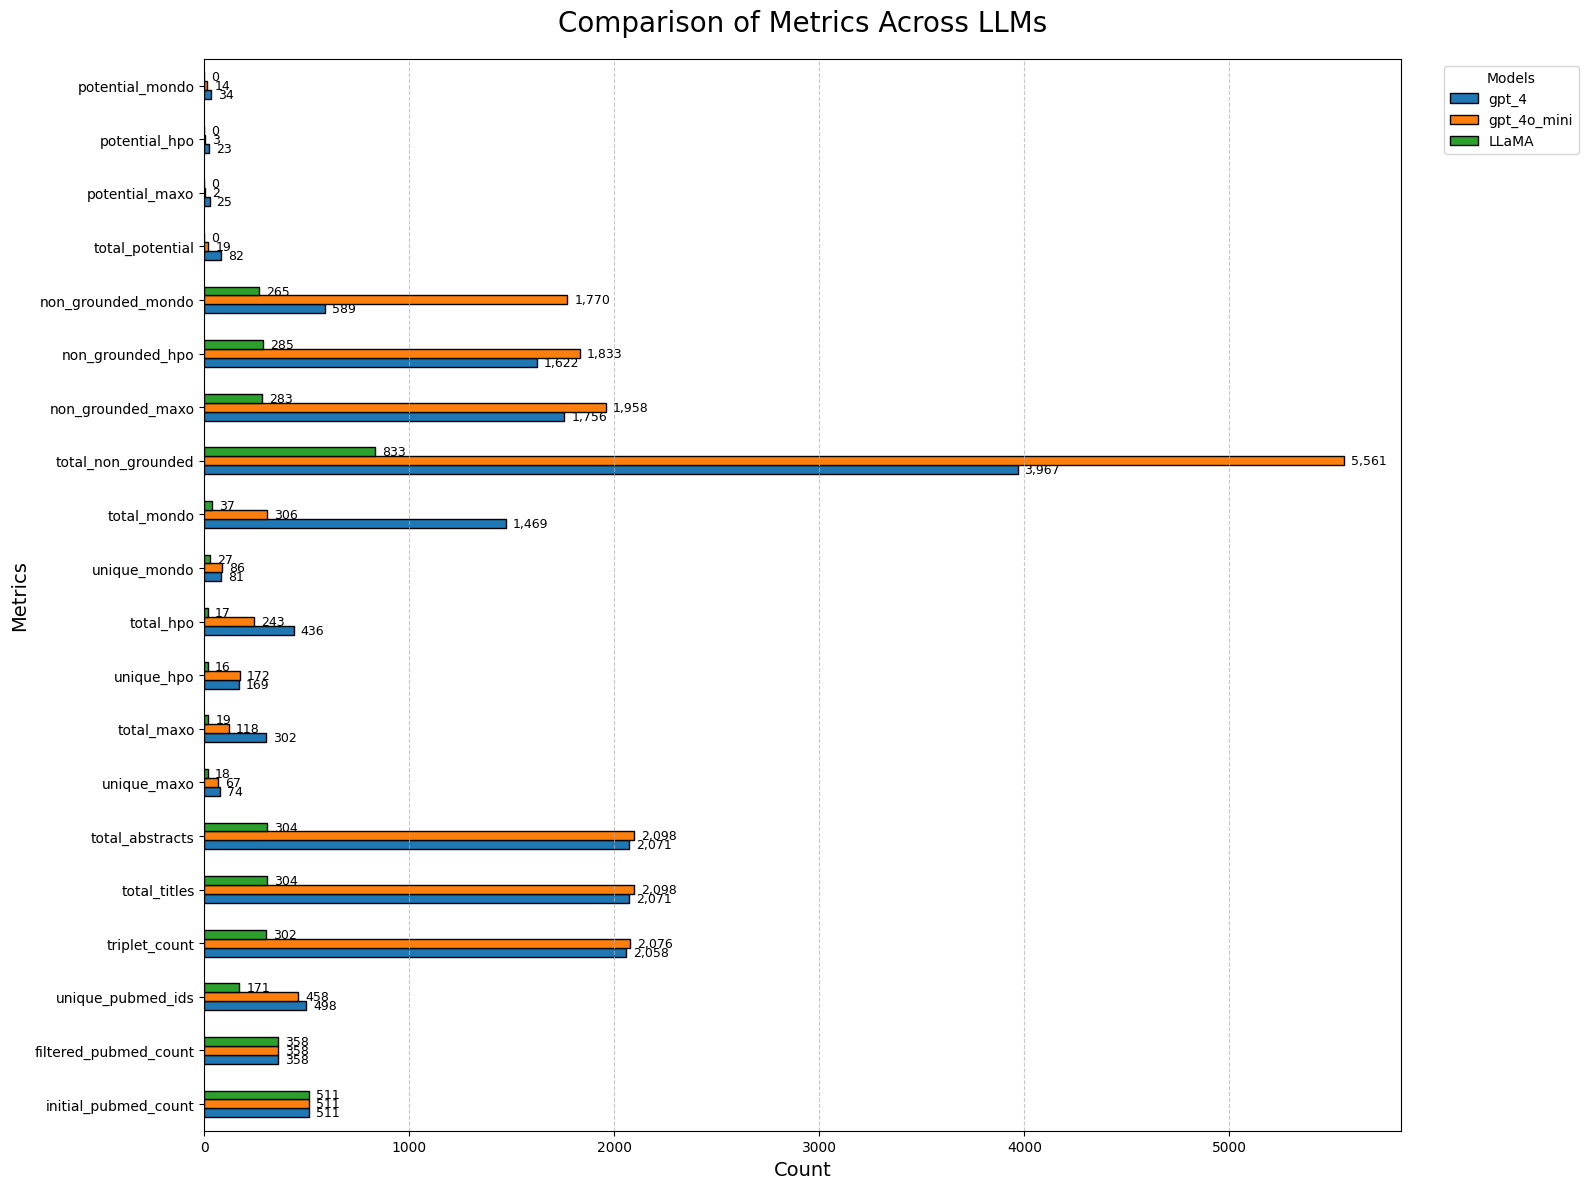

In [27]:
import matplotlib.pyplot as plt

# Transpose the DataFrame to metrics x models
transposed = summary_df.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 12))

# Plot horizontal bars with black edges for clarity
transposed.plot.barh(ax=ax, edgecolor='black')

# Add vertical grid lines for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Annotate each bar with its value
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        ax.annotate(
            f"{int(width):,}",
            xy=(width, bar.get_y() + bar.get_height() / 2),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            fontsize=9
        )

# Customize titles and labels
ax.set_title("Comparison of Metrics Across LLMs", fontsize=20, pad=20)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Metrics", fontsize=14)

# Place legend outside the plot
ax.legend(title="Models", bbox_to_anchor=(1.03, 1), loc="upper left")

plt.tight_layout()
plt.show()
